In [4]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

import pyro
from pyro.infer import MCMC, NUTS
import ot
import jax
import gc

from ex2mcmc.sampling_utils.adaptive_mc import Ex2MCMC, FlowMCMC
from ex2mcmc.sampling_utils.distributions import (
    Banana,
    IndependentNormal,
)
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.metrics.chain import ESS, acl_spectrum
from ex2mcmc.metrics.total_variation import (
    average_total_variation,
)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def sample_nuts(target, proposal, device = 'cpu', num_samples=1000, burn_in=1000, batch_size=1, rand_seed = 42):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()
    start_time = time.time()
    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(rand_seed)
    init_samples = proposal.sample((batch_size,)).to(device)
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].cpu()
    samples_true = np.array(q_true.view(-1, batch_size, dim))
    end_time = time.time()
    return end_time-start_time, samples_true

In [6]:
def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [8]:
n_steps = 1
dist = "banana"
dim = 100
scale_proposal = 1.
scale_isir = 5.
dist_class = "Banana"
dist_params = {
    "b": 0.02,
    "sigma":5.0,
}
sigma = 5.0
b = 0.02

In [9]:
target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

proposal_ex2 = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_isir,
    device=device,
)

### Generate ground-truth samples

In [10]:
N_samples = 2*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
for i in range(dim):
    if i % 2 == 0:
      True_samples[:,i] *= sigma
    else:
      True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b

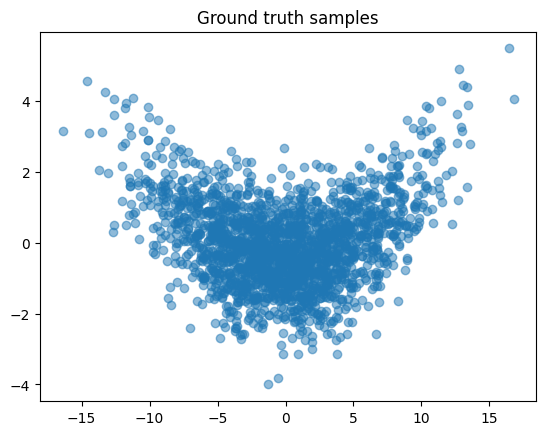

In [11]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,2],True_samples[:,3], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()

### Sample with NUTS

In [12]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [14]:
rand_seed = 42
time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=trunc_chain_len,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
)
print(sample_nuts_ref.shape)

torch.Size([1, 100])


Sample: 100%|██████████| 1500/1500 [00:18, 80.11it/s, step size=2.66e-01, acc. prob=0.871] 

(1000, 1, 100)


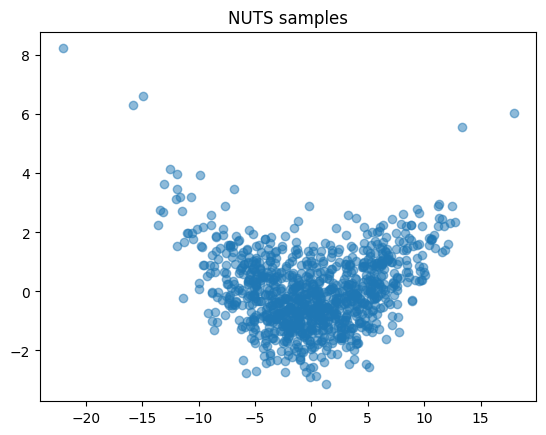

In [15]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1], alpha=0.5)
ax.set_title('NUTS samples')
plt.show()

In [16]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.033, Std: 0.009. 
ESS: 0.405 
EMD: 1580.955


### Sample with Ex2MCMC

In [17]:
params = {
      "N": 200,
      "grad_step": 0.1,
      "adapt_stepsize": True, #True
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0, #0.75
      "mala_steps": 3
}
        
n_steps_ex2 = 5000
batch_size = 1

In [18]:
mcmc = Ex2MCMC(**params, dim=dim)
pyro.set_rng_seed(43)
start = proposal_ex2.sample((batch_size,)).to(device)
# print(start)
# s = time.time()
out = mcmc(start, target, proposal_ex2, n_steps = n_steps_ex2)
# print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_ex2_final = sample[:,0,:]
print(sample_ex2_final.shape)

100%|██████████| 5000/5000 [00:26<00:00, 187.11it/s]


(5000, 100)


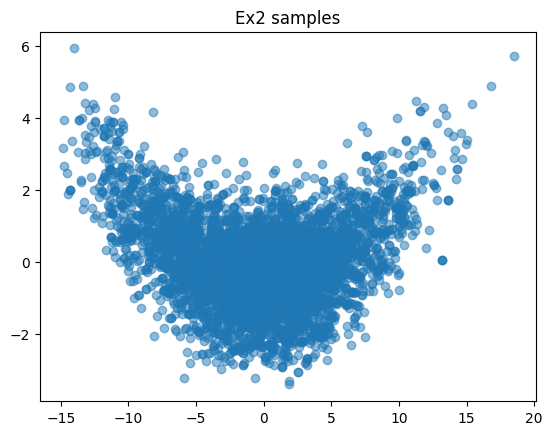

In [19]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1], alpha=0.5)
ax.set_title('Ex2 samples')
plt.show()

### Sample with Flex2MCMC (adaptive version)

In [20]:
params_flex = {
      "N": 200,
      "grad_step": 0.2,
      "adapt_stepsize": True,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_blocks": 4, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 800,
    }
}
batch_size = 1
torch.cuda.empty_cache()

In [21]:
pyro.set_rng_seed(47)
mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_blocks"], dim=dim, device = device)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    device,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()
gc.collect()
torch.cuda.empty_cache()
flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

 44%|████▍     | 355/800 [01:40<02:26,  3.05it/s]

In [ ]:
#sample from a normalizing flow
n_steps_flex2 = 2000
batch_size = 1
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
mcmc.N = 200
mcmc.mala_steps = 0
mcmc.grad_step = 0.1
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_flex2_new = sample
#resample with 0 mala steps
torch.cuda.empty_cache()
mcmc.mala_steps = 5
out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)
# print(out_new[1])
out_new = out_new[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new
print(sample_flex2_final.shape)

100%|██████████| 2000/2000 [00:50<00:00, 39.86it/s]

tensor([0.5018])
(2000, 1, 100)


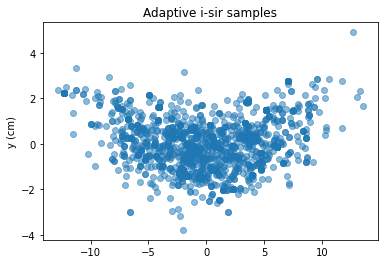

In [ ]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1],alpha = 0.5)
ax.set_title('Adaptive i-sir samples')
plt.show()

In [ ]:
trunc_chain_len = 1000
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_new,
                    name="Adaptive i-sir",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====Adaptive i-sir====
TV distance. Mean: 0.370, Std: 0.045. 
ESS: 0.057 
EMD: 1989.711


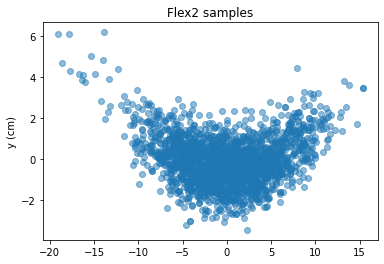

In [ ]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],alpha = 0.5)
ax.set_title('Flex2 samples')
plt.show()

In [ ]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.051, Std: 0.016. 
ESS: 0.222 
EMD: 1635.716


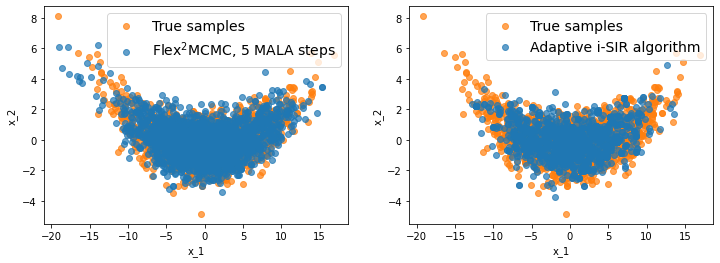

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4', alpha = 0.7, label = "Flex$^2$MCMC, 5 MALA steps")
axs[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs[1].scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1],c='#1f77b4', alpha = 0.7, label = "Adaptive i-SIR algorithm")

for ax in axs:
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
#ax.set_yscale('log')
plt.legend(fontsize=14)

plt.show()